## 0. Učitavanje podataka

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [1]:
import pandas as pd

df = pd.read_csv("data_cleaned.csv")
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0.0,...,7.0,437.63,3.0,Amex,65.0,883.17,Biometric,0.8494,0.0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0.0,...,13.0,478.76,4.0,Mastercard,186.0,2203.36,Password,0.0959,0.0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0.0,...,14.0,50.01,4.0,Visa,226.0,1909.29,Biometric,0.8400,0.0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0.0,...,8.0,182.48,4.0,Visa,76.0,1311.86,OTP,0.7935,0.0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0.0,...,14.0,328.69,4.0,Mastercard,140.0,966.98,Password,0.3819,1.0,1


## 1. Priprema podataka

In [2]:
filtered_df = df.loc[(df.Transaction_Type == "Online") & (df.Location == "London") & (df.Fraud_Label == 0), :]
filtered_df.Timestamp = pd.to_datetime(filtered_df.Timestamp)
daily_sum = filtered_df.groupby(filtered_df["Timestamp"].dt.date)["Transaction_Amount"].sum().reset_index()
daily_sum.columns = ['Date', 'Total_Transaction']
split_index = int(len(daily_sum) * 0.7)
train, test = daily_sum.iloc[:split_index], daily_sum.iloc[split_index:]

C:\Users\aland\AppData\Local\Temp\ipykernel_17612\3804135738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.Timestamp = pd.to_datetime(filtered_df.Timestamp)


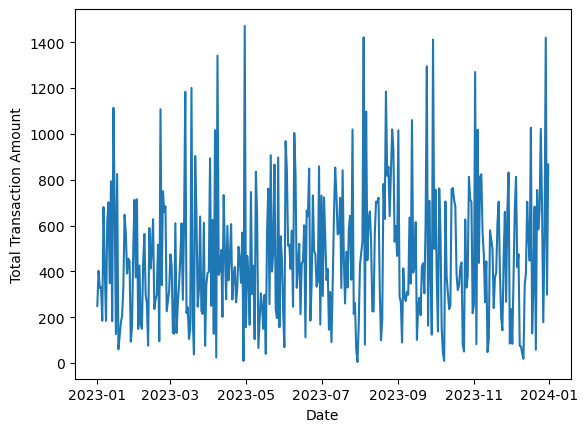

In [4]:
import matplotlib.pyplot as plt

plt.plot(daily_sum['Date'], daily_sum['Total_Transaction'])
plt.xlabel("Date")
plt.ylabel("Total Transaction Amount")
plt.show()

Ne postoje regularnosti, ali vidljivo je da postoje datumi koji iznosom odskaču.

In [5]:
split_index = int(len(daily_sum) * 0.7)
train, test = daily_sum.iloc[:split_index], daily_sum.iloc[split_index:]

## 2. Eksponencijalno zaglađivanje

In [6]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def calculate_es(model, printing=False):
    model = model.fit()
    forecast = model.forecast(len(test))
    rmse = root_mean_squared_error(test.Total_Transaction, forecast)
    mae = mean_absolute_error(test.Total_Transaction, forecast)
    
    if printing:
        print("Root Mean Squared Error: {:.2f}".format(rmse))
        print("Mean Absolute Error: {:.2f}".format(mae))
        plt.plot(train.Date, train.Total_Transaction, label="Train")
        plt.plot(test.Date, test.Total_Transaction, label="Test")
        plt.plot(test.Date, forecast, label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Total Transaction Amount")
        plt.legend()
        plt.show()
    return rmse, mae

Root Mean Squared Error: 311.72
Mean Absolute Error: 256.46


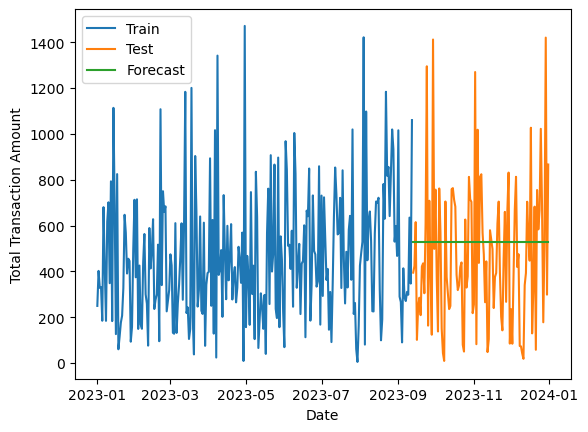

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

rmse, mae = calculate_es(ExponentialSmoothing(train.Total_Transaction), True)

Predikcija bez optimizacije parametara je ravna linija koja nije korisna.

### 2.1 Odabir hiperparametara

In [8]:
import numpy as np
from itertools import product

trend_options = ["add", "mul", None]
seasonal_options = ['add', 'mul', None]
seasonal_periods = np.arange(2, 14)
initialization_methods = ["estimated", "heuristic", "legacy-heuristic"]

results = []

for trend, seasonal, sp, im in product(trend_options, seasonal_options, seasonal_periods, initialization_methods):
    if seasonal is None and sp is not None:
        continue
    model = ExponentialSmoothing(
            train.Total_Transaction,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method=im
        )
    rmse, mae = calculate_es(model)
    results.append({
        "trend": trend,
        "seasonal": seasonal,
        "seasonal_periods": sp,
        "initialization_method": im,
        "RMSE": rmse,
        "MAE": mae
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmode

,trend,seasonal,seasonal_periods,initialization_method,RMSE,MAE
175,None,add,12,heuristic,303.482491,243.559089
174,None,add,12,estimated,304.379798,245.415902
191,None,mul,5,legacy-heuristic,305.208104,246.476690
211,None,mul,12,heuristic,305.365319,245.195072
210,None,mul,12,estimated,305.585898,245.688117
...,...,...,...,...,...,...
143,mul,mul,13,legacy-heuristic,434.045935,369.853805
110,mul,mul,2,legacy-heuristic,453.390074,382.102544
11,add,add,5,legacy-heuristic,464.285481,354.138434
46,add,mul,5,heuristic,485.371453,373.833408


#### Parametri s najmanjim RMSE

Root Mean Squared Error: 303.48
Mean Absolute Error: 243.56


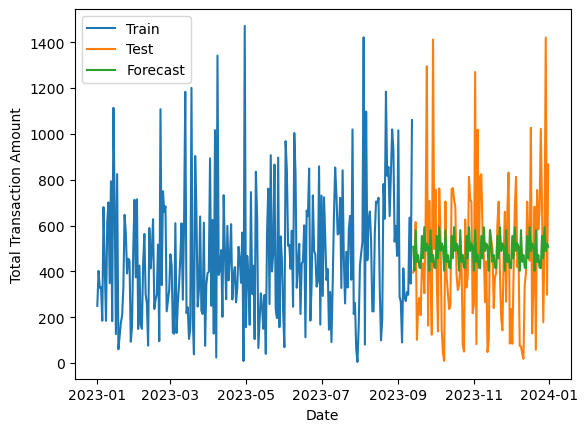

In [9]:
model = ExponentialSmoothing(train.Total_Transaction, trend=None, seasonal="add", seasonal_periods=12, initialization_method="heuristic")
rmse, mae = calculate_es(model, True)

Nakon optimizacije parametara model je poboljšan, no i dalje RMSE i MAE su veliki.

## 3. ARIMA

In [10]:
def calculate_arima(model, printing=False):
    model = model.fit()
    forecast = model.forecast(len(test))
    rmse = root_mean_squared_error(test.Total_Transaction, forecast)
    mae = mean_absolute_error(test.Total_Transaction, forecast)
    if printing:
        print("Root Mean Squared Error: {:.2f}".format(rmse))
        print("Mean Absolute Error: {:.2f}".format(mae))
        plt.plot(train.Date, train.Total_Transaction, label="Train")
        plt.plot(test.Date, test.Total_Transaction, label="Test")
        plt.plot(test.Date, forecast, label="Forecast")
        plt.xlabel("Date")
        plt.ylabel("Total Transaction Amount")
        conf_int = model.get_forecast(len(test)).conf_int()
        plt.fill_between(test.Date, conf_int.iloc[:, 0], conf_int.iloc[:, 1], label="Confidence Interval", color="pink")
        plt.legend()
        plt.show()
    
    return rmse, mae

Root Mean Squared Error: 305.25
Mean Absolute Error: 243.14


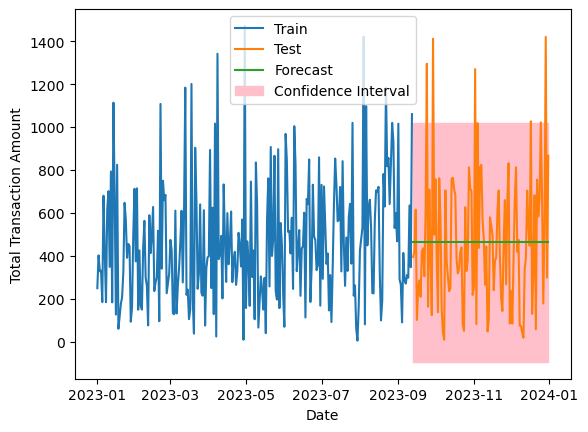

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.Total_Transaction)
rmse, mae = calculate_arima(model, True)

Predikcija s parametrima (0,0,0) je ravna linija (isto kao i kod eksponencijalnoga zaglađivanje bez optimizacije). Takva predikcija nam nije korisna. Širina intervala pouzadnosti je velika što nam govori da model nije siguran u svoju predikciju zbog toga što podaci jako variraju.

### Parametar p

In [12]:
import numpy as np

p_options = np.arange(0, 10)

results = []
for p in p_options:
    model = ARIMA(train.Total_Transaction, order=(p,0,0))
    rmse, mae = calculate_arima(model)
    results.append({
        "p":p,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,p,RMSE,MAE
9,9,304.546892,242.306962
8,8,304.663056,242.408092
7,7,304.664550,242.425113
6,6,304.739610,242.591776
5,5,304.941334,242.880678
4,4,305.013381,242.928806
1,1,305.190985,242.642376
0,0,305.248286,243.141630
3,3,305.432097,243.301410
2,2,305.606337,243.582623


Root Mean Squared Error: 304.55
Mean Absolute Error: 242.31


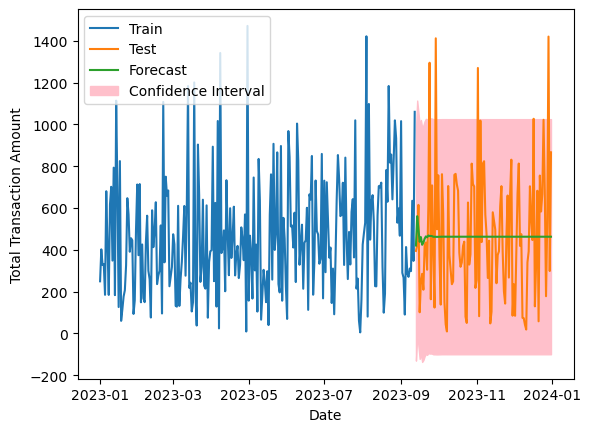

In [13]:
model = ARIMA(train.Total_Transaction, order=(9,0,0))
rmse, mae = calculate_arima(model, True)

Parametar p utječe tako da predikcija na početku nije više ravna crta, no kasnije opet postaje ravna crta. Pogreška se malo smanjila.

### Parametar q

In [14]:
q_options = np.arange(0, 10)

results = []
for q in q_options:
    model = ARIMA(train.Total_Transaction, order=(0,0,q))
    rmse, mae = calculate_arima(model)
    results.append({
        "q":q,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,q,RMSE,MAE
8,8,304.679638,242.566536
7,7,304.686705,242.530471
9,9,304.709366,242.591532
6,6,304.764950,242.606624
5,5,305.157039,243.077432
4,4,305.159696,243.078223
1,1,305.185919,242.698628
0,0,305.248286,243.141630
3,3,305.330422,243.261584
2,2,305.412121,243.358545


Root Mean Squared Error: 304.68
Mean Absolute Error: 242.57


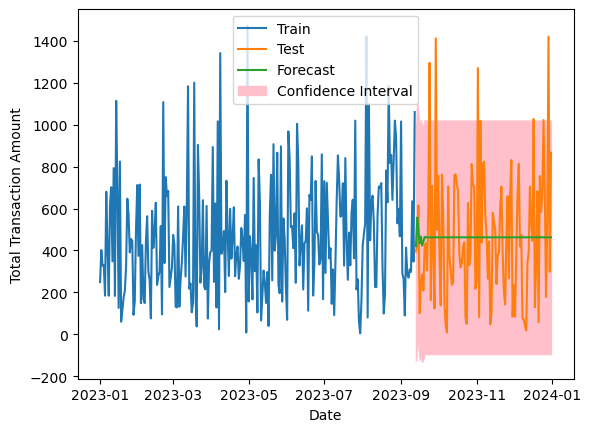

In [15]:
model = ARIMA(train.Total_Transaction, order=(0,0,8))
rmse, mae = calculate_arima(model, True)

Parametar q utječe tako da predikcija na početku nije više ravna crta, no kasnije opet postaje ravna crta. Pogreška se malo smanjila.

### Parametar d

In [16]:
d_options = np.arange(0, 10)

results = []
for d in d_options:
    model = ARIMA(train.Total_Transaction, order=(0,d,0))
    rmse, mae = calculate_arima(model)
    results.append({
        "d":d,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,d,RMSE,MAE
0,0,3.052483e+02,2.431416e+02
1,1,6.688531e+02,6.163542e+02
2,2,4.570694e+04,3.982774e+04
3,3,2.765130e+06,2.077107e+06
4,4,1.418071e+08,9.469924e+07
5,5,5.668497e+09,3.441582e+09
6,6,1.795673e+11,1.006767e+11
7,7,4.690416e+12,2.456118e+12
8,8,1.031904e+14,5.090572e+13
9,9,1.853674e+15,8.674812e+14


Root Mean Squared Error: 305.25
Mean Absolute Error: 243.14


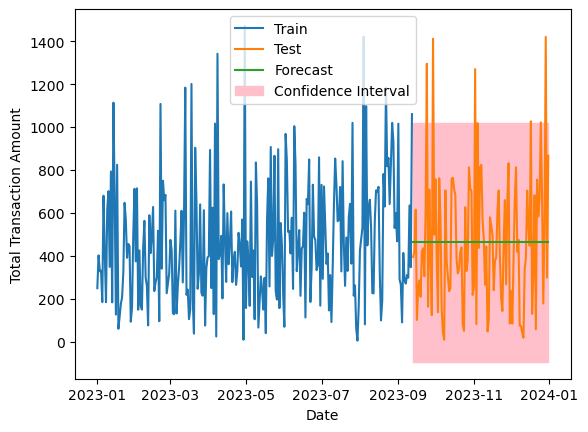

In [17]:
model = ARIMA(train.Total_Transaction, order=(0,0,0))
rmse, mae = calculate_arima(model, True)

Optimizacijom parametra d dobili smo da je optimalna vrijednost 0 kao i na početku te je greška ostala ista.

### Parametri p, d i q

In [18]:
p_options = np.arange(0, 5)
d_options = np.arange(0, 5)
q_options = np.arange(0, 5)

results = []
for p, d, q in product(p_options, d_options, q_options):
    try:
        model = ARIMA(train.Total_Transaction, order=(p,d,q), enforce_invertibility=False)
        rmse, mae = calculate_arima(model)
        results.append({
            "p":p,
            "d":d,
            "q":q,
            "RMSE":rmse,
            "MAE":mae
        })
    except Exception:
        continue

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-p

,p,d,q,RMSE,MAE
104,4,0,4,3.004742e+02,2.394847e+02
79,3,0,4,3.046265e+02,2.421576e+02
101,4,0,1,3.049153e+02,2.426970e+02
102,4,0,2,3.049433e+02,2.427020e+02
53,2,0,3,3.049560e+02,2.427237e+02
...,...,...,...,...,...
120,4,4,0,3.596162e+06,2.430557e+06
95,3,4,0,7.045684e+06,4.740865e+06
70,2,4,0,1.488749e+07,9.986633e+06
45,1,4,0,3.942819e+07,2.638138e+07


C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error: 300.47
Mean Absolute Error: 239.48


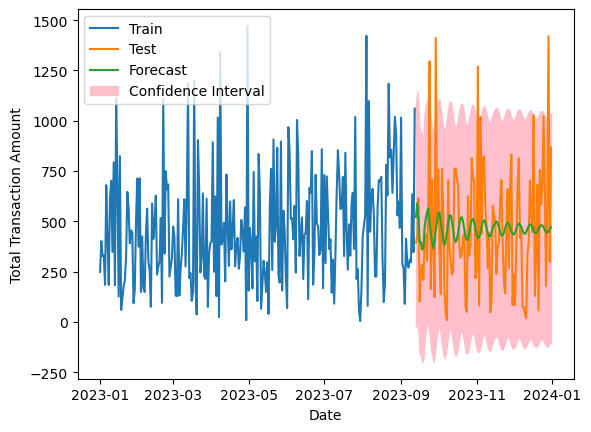

In [19]:
model = ARIMA(train.Total_Transaction, order=(4,0,4), enforce_invertibility=False)
rmse, mae = calculate_arima(model, True)

Model se uspio poboljšati kada optimiziramo sve parametre.

### Parametar s

In [20]:
s_options = np.arange(0, 30)

results = []
for s in s_options:
    try:
        model = ARIMA(train.Total_Transaction, order=(4,0,4), seasonal_order=(1,1,1,s), enforce_invertibility=False)
        rmse, mae = calculate_arima(model)
        results.append({
            "s":s,
            "RMSE":rmse,
            "MAE":mae
        })
    except Exception:
        continue

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-p

,s,RMSE,MAE
18,23,305.818153,235.785338
10,15,310.797575,248.771380
11,16,313.974845,252.808377
12,17,316.144945,252.296888
1,6,317.365763,260.990904
2,7,321.262281,263.911247
5,10,322.264303,261.388134
19,24,322.676087,267.906044
0,5,325.761870,263.006111
9,14,326.560963,265.571316


C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error: 305.82
Mean Absolute Error: 235.79


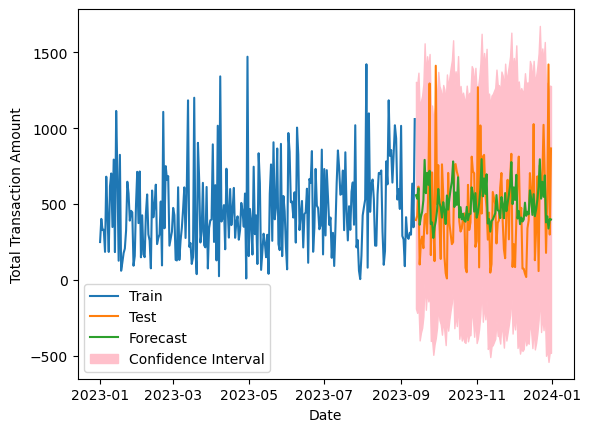

In [21]:
model = ARIMA(train.Total_Transaction, order=(4,0,4), seasonal_order=(1,1,1,23), enforce_invertibility=False)
rmse, mae = calculate_arima(model, True)

Kada dodamo parametar s, pogreška se povećala. No predikcija izgleda "prirodnije" nego bez tog parametra.

## 4. Facebook Prophet

Importing plotly failed. Interactive plots will not work.
18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing


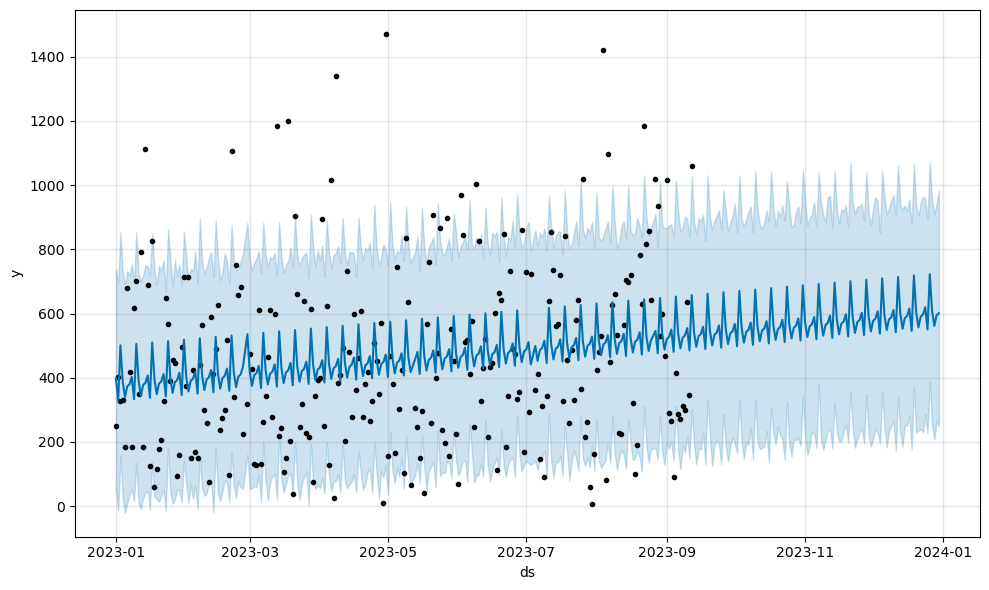

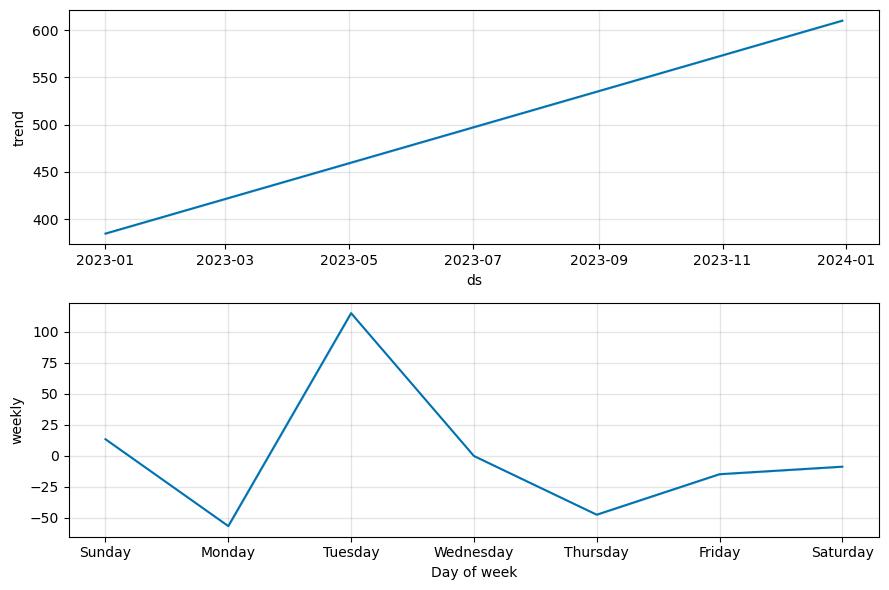

Root Mean Squared Error: 329.66
Mean Absolute Error: 269.23


In [22]:
from prophet import Prophet

prophet_data = daily_sum.copy()
prophet_data.columns = ["ds", "y"]

split_index = int(len(prophet_data) * 0.7)
train_prophet, test_prophet = prophet_data.iloc[:split_index], prophet_data.iloc[split_index:]

model = Prophet()
model.fit(train_prophet)

future = model.make_future_dataframe(len(test_prophet))
forecast = model.predict(future)

model.plot(forecast)
model.plot_components(forecast)
plt.show()

rmse = root_mean_squared_error(test.Total_Transaction, forecast.yhat[split_index:])
mae = mean_absolute_error(test.Total_Transaction, forecast.yhat[split_index:])
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))

### 4.1 Optimizacija hiperparametara

In [23]:
holidays = pd.DataFrame({
    'holiday': 'promo',
    'ds': pd.to_datetime([
        '2023-11-24',  # Black Friday
        '2023-11-27',  # Cyber Monday
        '2023-11-12',  # Diwali
        '2023-11-11',  # Singles' day
        '2023-11-23',  # Thanksgiving
        '2023-11-26',  # Boxing day
        '2023-02-14',  # Valentine's day
    ]),
})

fourier_orders = np.arange(1, 10)
results = []
for fo in fourier_orders:
    model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False, holidays=holidays)

    model.add_seasonality(name='weekly', period=7, fourier_order=fo)

    model.fit(train_prophet)

    future = model.make_future_dataframe(periods=len(test_prophet))
    forecast = model.predict(future)
    
    rmse = root_mean_squared_error(test_prophet.y, forecast.yhat[split_index:])
    mae = mean_absolute_error(test_prophet.y, forecast.yhat[split_index:])
    
    results.append({
        "fo":fo,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:56 - cmdstanpy - INFO - Chain [1] start processing
18:50:56 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1]

,fo,RMSE,MAE
0,1,326.080543,267.269402
1,2,327.241480,266.953778
5,6,328.183829,267.742109
2,3,328.457431,268.013441
4,5,328.516812,268.077240
7,8,330.263942,269.831788
3,4,331.691941,271.243958
8,9,332.082703,271.636365
6,7,333.109507,272.658763


18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing


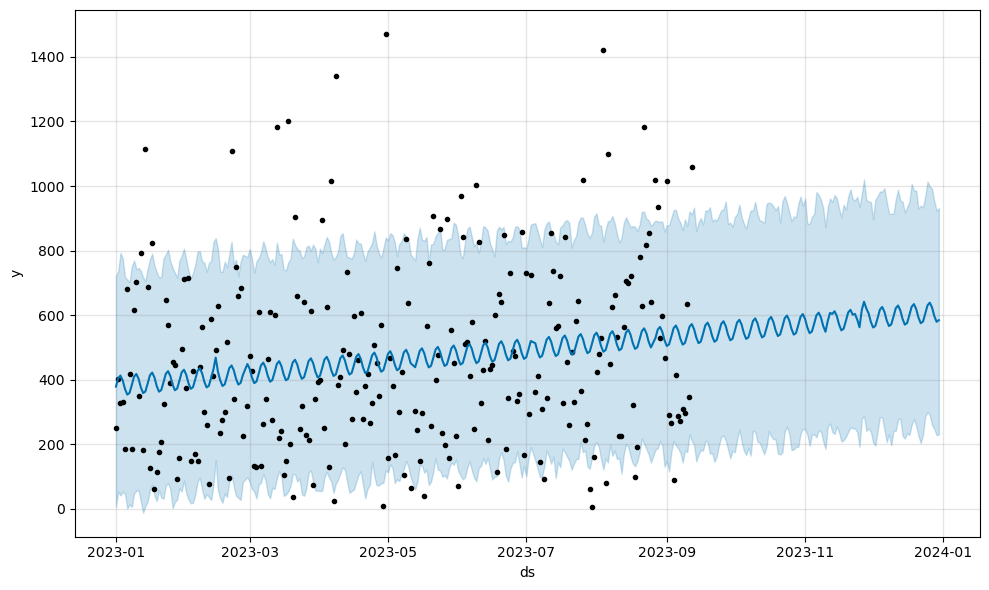

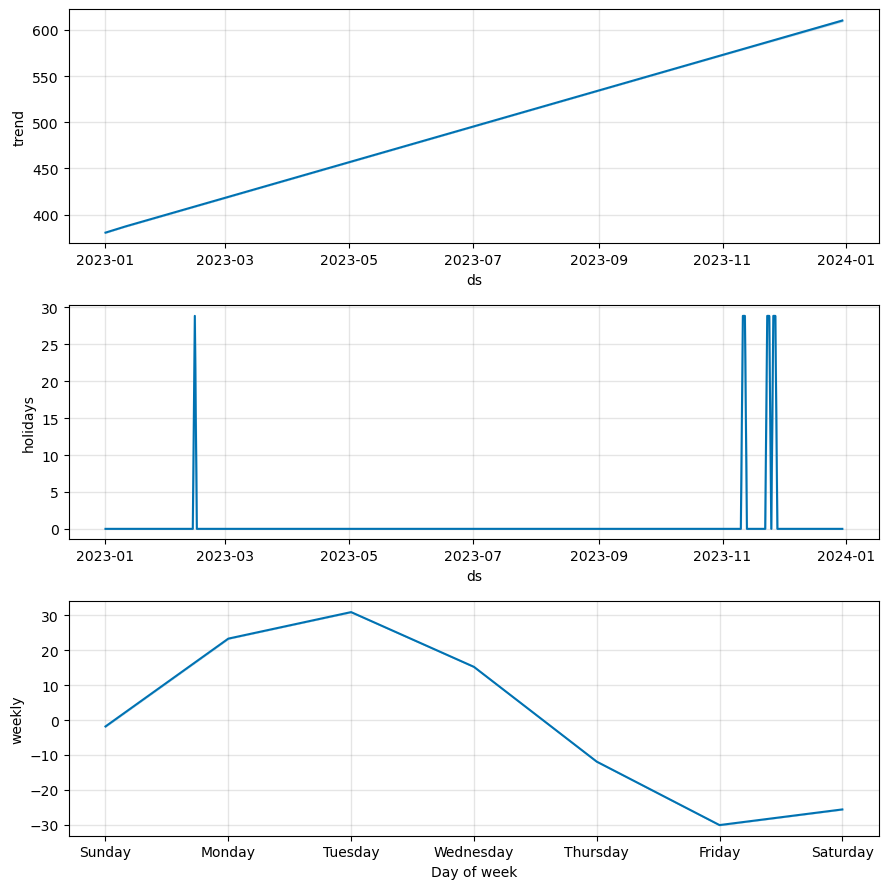

Root Mean Squared Error: 326.08
Mean Absolute Error: 267.27


In [24]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False, holidays=holidays)

model.add_seasonality(name='weekly', period=7, fourier_order=1)

model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test_prophet))
forecast = model.predict(future)
    
model.plot(forecast)
model.plot_components(forecast)
plt.show()

rmse = root_mean_squared_error(test.Total_Transaction, forecast.yhat[split_index:])
mae = mean_absolute_error(test.Total_Transaction, forecast.yhat[split_index:])
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))

Dodavanjem određenih datuma pogreška se malo smanjila. Prophet radi lošije s obzirom na ostale algoritme.

## 5. RandomForestRegressor

In [58]:
filtered_df = df.loc[(df.Transaction_Type == "Online") & (df.Location == "London") & (df.Fraud_Label == 0), :]
filtered_df.Timestamp = pd.to_datetime(filtered_df.Timestamp)
daily_sum = filtered_df.groupby(filtered_df["Timestamp"].dt.date)["Transaction_Amount"].sum().reset_index()
daily_sum.columns = ['Date', 'Total_Transaction']
split_index = int(len(daily_sum) * 0.7)
train, test = daily_sum.iloc[:split_index], daily_sum.iloc[split_index:]

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1).fit(str(train["Date"]), train["Total_Transaction"])
predicts = model.predict(str(test["Date"]))

ValueError: could not convert string to float: '0      2023-01-01\n1      2023-01-02\n2      2023-01-03\n3      2023-01-04\n4      2023-01-05\n          ...    \n246    2023-09-08\n247    2023-09-09\n248    2023-09-10\n249    2023-09-11\n250    2023-09-12\nName: Date, Length: 251, dtype: object'

In [ ]:
plt.plot(train.Date, train.Total_Transaction, label="Train")
plt.plot(test.Date, test.Total_Transaction, label="Test")
plt.plot(test.Date, predicts, label="Forecast")
plt.xlabel("Date")
plt.ylabel("Total Transaction Amount")
plt.legend()
plt.show()

In [33]:
rmse = root_mean_squared_error(test.Total_Transaction, predicts)
mae = mean_absolute_error(test.Total_Transaction, predicts)
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))

Root Mean Squared Error: 198.31
Mean Absolute Error: 160.11


Rezultati su bolji s obzirom na ostale algoritme.

## 6. Generirani signal

In [34]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

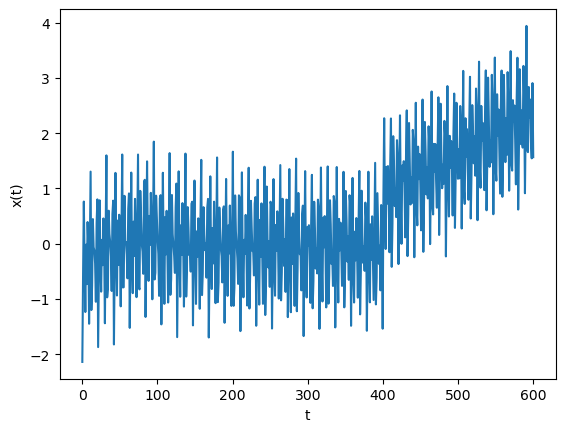

In [35]:
plt.plot(t, pts)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.show()

In [36]:
train_indexes = np.arange(0, len(pts_train))
test_indexes = np.arange(len(pts_train), len(pts_train) + len(pts_test))

Signal se sastoji od 2 periodična sawtooth signala. Također, postoje 4 trenda različitih duljina i orijentacija (3 trenda su rastuća, a jedan padajući). Signal također sadrži blagi šum.

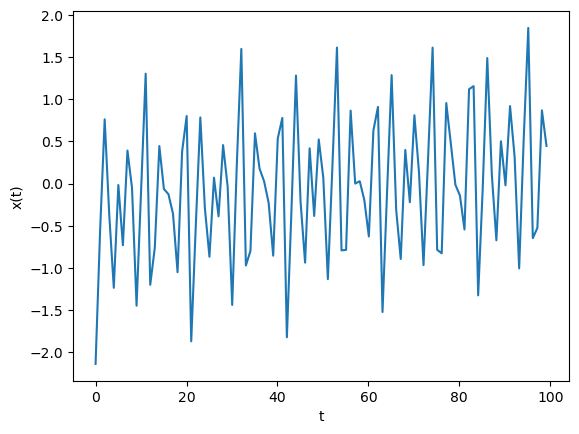

In [37]:
plt.plot(t[:100], pts[:100])
plt.xlabel("t")
plt.ylabel("x(t)")
plt.show()

### 6.2. Eksponencijalno zaglađivanje

In [38]:
def calculate_generated(model):
    model = model.fit()
    forecast = model.forecast(len(pts_test))
    rmse = root_mean_squared_error(pts_test, forecast)
    mae = mean_absolute_error(pts_test, forecast)
    plt.plot(train_indexes, pts_train, label="Train")
    plt.plot(test_indexes, pts_test, label="Test")
    plt.plot(test_indexes, forecast, label="Forecast")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.legend()
    plt.show()
    print("Root Mean Squared Error: {:.2f}".format(rmse))
    print("Mean Absolute Error: {:.2f}".format(mae))

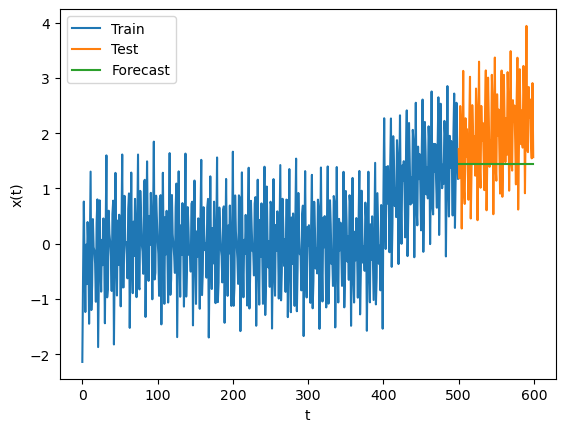

Root Mean Squared Error: 0.97
Mean Absolute Error: 0.79


In [39]:
model = ExponentialSmoothing(pts_train)
calculate_generated(model)

In [40]:
from itertools import product

trend_options = ["add", None]
seasonal_options = ["add", None]
seasonal_periods = np.arange(2, 25, 1)
initialization_methods = ["estimated", "heuristic", "legacy-heuristic"]

results = []

for trend, seasonal, sp, im in product(trend_options, seasonal_options, seasonal_periods, initialization_methods):
    model = ExponentialSmoothing(
            pts_train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=sp,
            initialization_method = im
        ).fit()
    forecast = model.forecast(len(pts_test))
    rmse = root_mean_squared_error(pts_test, forecast)
    mae = mean_absolute_error(pts_test, forecast)
    results.append({
        "trend": trend,
        "seasonal": seasonal,
        "seasonal_periods": sp,
        "initialization_method": im,
        "RMSE": rmse,
        "MAE": mae
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,trend,seasonal,seasonal_periods,initialization_method,RMSE,MAE
58,add,add,21,heuristic,0.257759,0.155745
59,add,add,21,legacy-heuristic,0.279810,0.190591
57,add,add,21,estimated,0.335147,0.262459
197,None,add,21,legacy-heuristic,0.513569,0.449977
195,None,add,21,estimated,0.518741,0.455380
...,...,...,...,...,...,...
185,None,add,17,legacy-heuristic,1.065705,0.875284
184,None,add,17,heuristic,1.065717,0.874618
145,None,add,4,heuristic,1.092086,0.899807
144,None,add,4,estimated,1.092608,0.900210


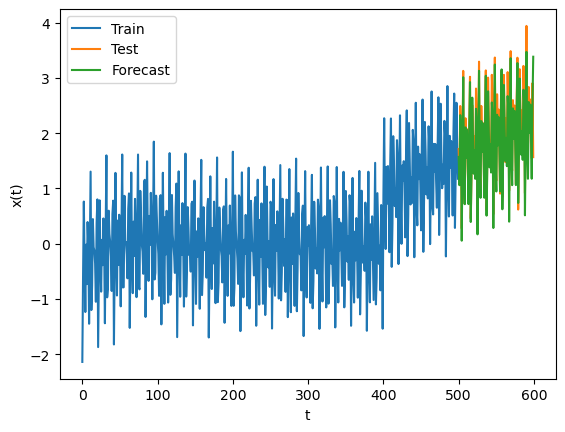

Root Mean Squared Error: 0.28
Mean Absolute Error: 0.19


In [41]:
model = ExponentialSmoothing(pts_train, trend="add", seasonal="add", seasonal_periods=21, initialization_method="legacy-heuristic")
calculate_generated(model)

### 6.3. ARIMA

In [42]:
def calculate_arima_generated(model, printing=False):
    model = model.fit()
    forecast = model.forecast(len(pts_test))
    rmse = root_mean_squared_error(pts_test, forecast)
    mae = mean_absolute_error(pts_test, forecast)
    if printing:
        print("Root Mean Squared Error: {:.2f}".format(rmse))
        print("Mean Absolute Error: {:.2f}".format(mae))
        plt.plot(train_indexes, pts_train, label="Train")
        plt.plot(test_indexes, pts_test, label="Test")
        plt.plot(test_indexes, forecast, label="Forecast")
        plt.xlabel("t")
        plt.ylabel("x(t)")
        conf_int = model.get_forecast(len(pts_test)).conf_int()
        plt.fill_between(test_indexes, conf_int[:, 0], conf_int[:, 1], label="Confidence Interval", color="pink")
        plt.legend()
        plt.show()
    
    return rmse, mae

Root Mean Squared Error: 1.93
Mean Absolute Error: 1.76


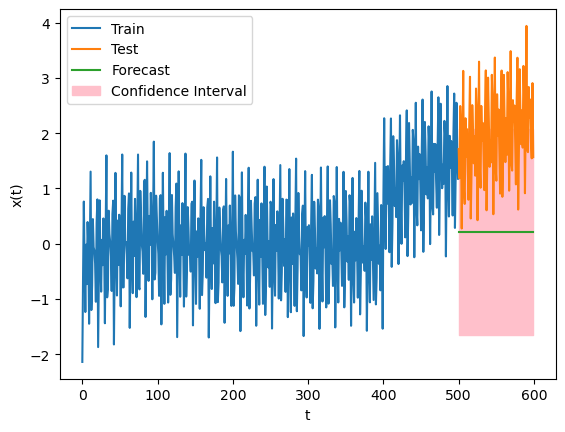

In [43]:
model = ARIMA(pts_train, order=(0,0,0))
rmse, mae = calculate_arima_generated(model, True)

#### Parametar p

In [44]:
p_options = np.arange(0, 10)

results = []
for p in p_options:
    model = ARIMA(pts_train, order=(p,0,0))
    rmse, mae = calculate_arima_generated(model)
    results.append({
        "p":p,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,p,RMSE,MAE
9,9,0.546889,0.465983
8,8,0.759910,0.608248
7,7,0.760261,0.608378
6,6,0.767627,0.602538
5,5,1.175926,0.971504
4,4,1.835441,1.632625
3,3,1.890332,1.698631
1,1,1.932985,1.758842
0,0,1.933780,1.760092
2,2,1.936419,1.763959


C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error: 0.55
Mean Absolute Error: 0.47


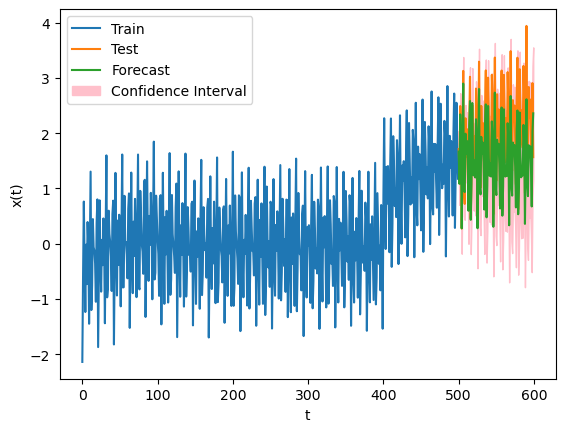

In [45]:
model = ARIMA(pts_train, order=(9,0,0))
rmse, mae = calculate_arima_generated(model, True)

#### Parametar q

In [46]:
q_options = np.arange(0, 10)

results = []
for q in q_options:
    model = ARIMA(pts_train, order=(0,0,q))
    rmse, mae = calculate_arima_generated(model)
    results.append({
        "q":q,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,q,RMSE,MAE
8,8,1.889159,1.698700
9,9,1.894180,1.705473
7,7,1.894556,1.705376
6,6,1.910135,1.726410
4,4,1.910603,1.727246
5,5,1.910992,1.729108
3,3,1.920193,1.739464
1,1,1.932827,1.758195
0,0,1.933780,1.760092
2,2,6.345812,2.701380


Root Mean Squared Error: 1.89
Mean Absolute Error: 1.70


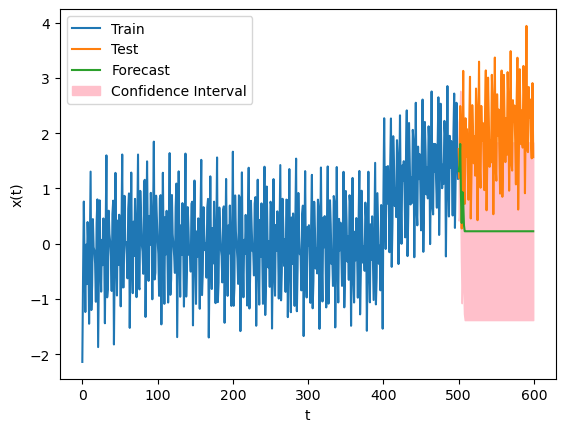

In [47]:
model = ARIMA(pts_train, order=(0,0,8))
rmse, mae = calculate_arima_generated(model, True)

#### Parametar d

In [48]:
d_options = np.arange(0, 10)

results = []
for d in d_options:
    model = ARIMA(pts_train, order=(0,d,0))
    rmse, mae = calculate_arima_generated(model)
    results.append({
        "d":d,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,d,RMSE,MAE
1,1,1.132848e+00,9.368550e-01
0,0,1.933780e+00,1.760092e+00
2,2,3.204692e+01,2.793108e+01
3,3,6.584070e+02,4.884800e+02
4,4,1.612146e+05,1.074827e+05
5,5,7.500383e+06,4.555403e+06
6,6,1.263698e+08,7.109678e+07
7,7,2.794595e+09,1.455513e+09
8,8,2.367675e+11,1.166902e+11
9,9,7.892262e+12,3.693324e+12


Root Mean Squared Error: 1.13
Mean Absolute Error: 0.94


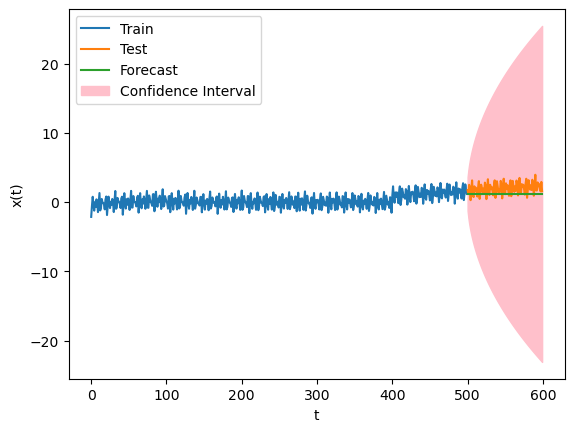

In [49]:
model = ARIMA(pts_train, order=(0,1,0))
rmse, mae = calculate_arima_generated(model, True)

#### Parametri p, d i q

In [50]:
p_options = np.arange(0, 5)
d_options = np.arange(0, 5)
q_options = np.arange(0, 5)

results = []
for p, d, q in product(p_options, d_options, q_options):
    model = ARIMA(pts_train, order=(p,d,q))
    rmse, mae = calculate_arima_generated(model)
    results.append({
        "p":p,
        "d":d,
        "q":q,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-p

,p,d,q,RMSE,MAE
114,4,2,4,0.429202,0.353959
109,4,1,4,0.566115,0.450736
108,4,1,3,0.599473,0.443397
113,4,2,3,0.649903,0.488634
107,4,1,2,0.697556,0.524464
...,...,...,...,...,...
120,4,4,0,12581.361318,8457.824505
95,3,4,0,24795.222840,16646.558503
45,1,4,0,54148.011763,36023.914471
70,2,4,0,58988.571267,39592.690703


C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error: 0.43
Mean Absolute Error: 0.35


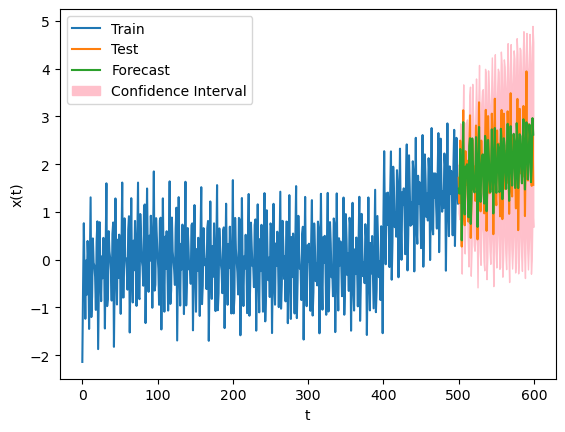

In [51]:
model = ARIMA(pts_train, order=(4,2,4))
rmse, mae = calculate_arima_generated(model, True)

#### Parametar s

In [52]:
s_options = np.arange(5, 10)

results = []
for s in s_options:
    model = ARIMA(pts_train, order=(4,2,4), seasonal_order=(1,1,1,s))
    rmse, mae = calculate_arima_generated(model)
    results.append({
        "s":s,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\aland\anaconda3\envs\dap-env\Lib\site-p

,s,RMSE,MAE
4,9,0.320642,0.217776
2,7,0.391094,0.323399
0,5,0.408665,0.317320
3,8,0.890914,0.721729
1,6,927891.812370,922864.502127


C:\Users\aland\anaconda3\envs\dap-env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Squared Error: 0.32
Mean Absolute Error: 0.22


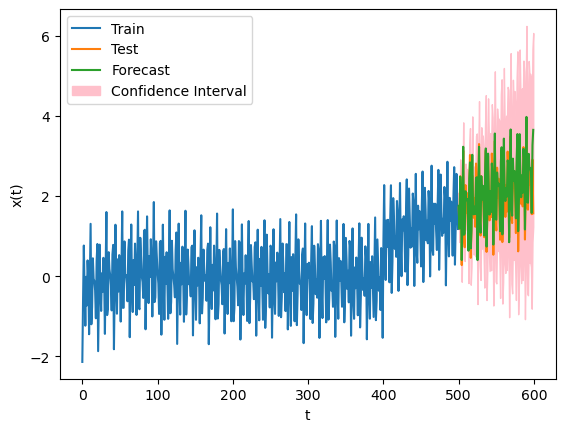

In [53]:
model = ARIMA(pts_train, order=(4,2,4), seasonal_order=(1,1,1,9))
rmse, mae = calculate_arima_generated(model, True)

Optimizacijom hiperparametara i dodavanjem sezonalnosti pogreška se smanjila.

### 6.4. Facebook Prophet

In [54]:
from datetime import datetime, timedelta

train_start = datetime(2024, 1, 1)
test_start = train_start + timedelta(days=len(pts_train))

train_dates = pd.date_range(start=train_start, periods=len(pts_train), freq='D')
test_dates = pd.date_range(start=test_start, periods=len(pts_test), freq='D')

prophet_train = pd.DataFrame({'ds': train_dates, 'y': pts_train})
prophet_test = pd.DataFrame({'ds': test_dates, 'y': pts_test})


18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing


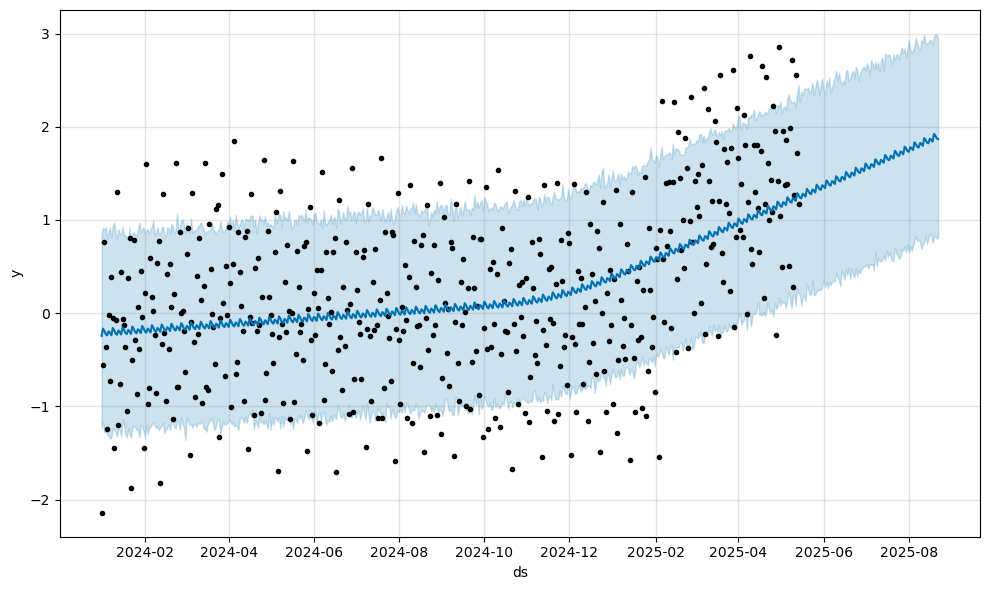

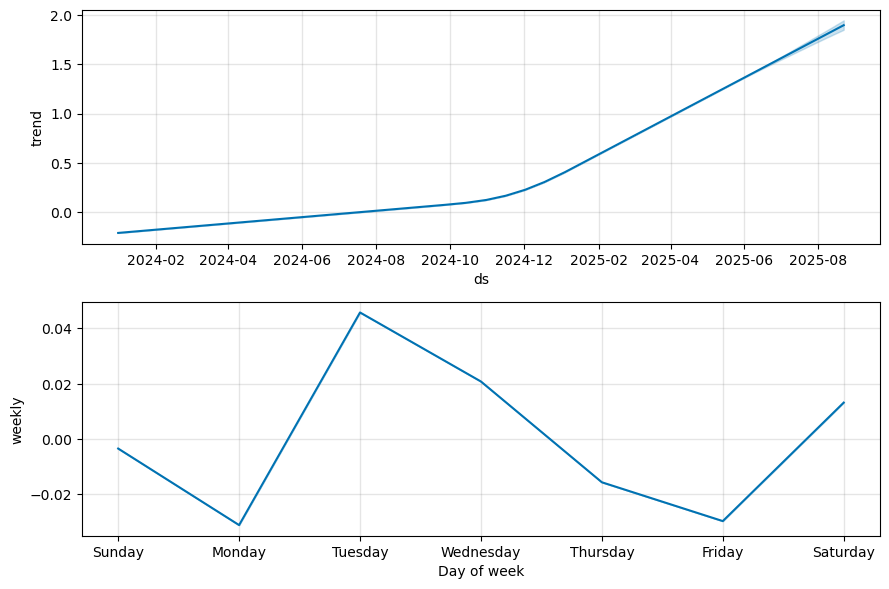

Root Mean Squared Error: 0.88
Mean Absolute Error: 0.70


In [55]:
model = Prophet()
model.fit(prophet_train)

future = model.make_future_dataframe(len(prophet_test))
forecast = model.predict(future)

model.plot(forecast)
model.plot_components(forecast)
plt.show()

split_index = len(prophet_train)
rmse = root_mean_squared_error(prophet_test.y, forecast.yhat[split_index:])
mae = mean_absolute_error(prophet_test.y, forecast.yhat[split_index:])
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))

#### 6.4.1 Optimizacija hiperparametara

In [56]:
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
fourier_orders = np.arange(1, 10)
results = []
for fo in fourier_orders:
    model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False)

    model.add_seasonality(name='my_period', period=21, fourier_order=fo)

    model.fit(prophet_train)

    future = model.make_future_dataframe(periods=len(prophet_test))
    forecast = model.predict(future)
    
    rmse = root_mean_squared_error(prophet_test.y, forecast.yhat[split_index:])
    mae = mean_absolute_error(prophet_test.y, forecast.yhat[split_index:])
    
    results.append({
        "fo":fo,
        "RMSE":rmse,
        "MAE":mae
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:21 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1]

,fo,RMSE,MAE
8,9,0.557633,0.428537
7,8,0.571104,0.443030
6,7,0.574664,0.446716
5,6,0.596899,0.496731
4,5,0.598299,0.498555
1,2,0.864043,0.703862
0,1,0.868248,0.704490
3,4,0.872843,0.705824
2,3,0.875242,0.707813


18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing


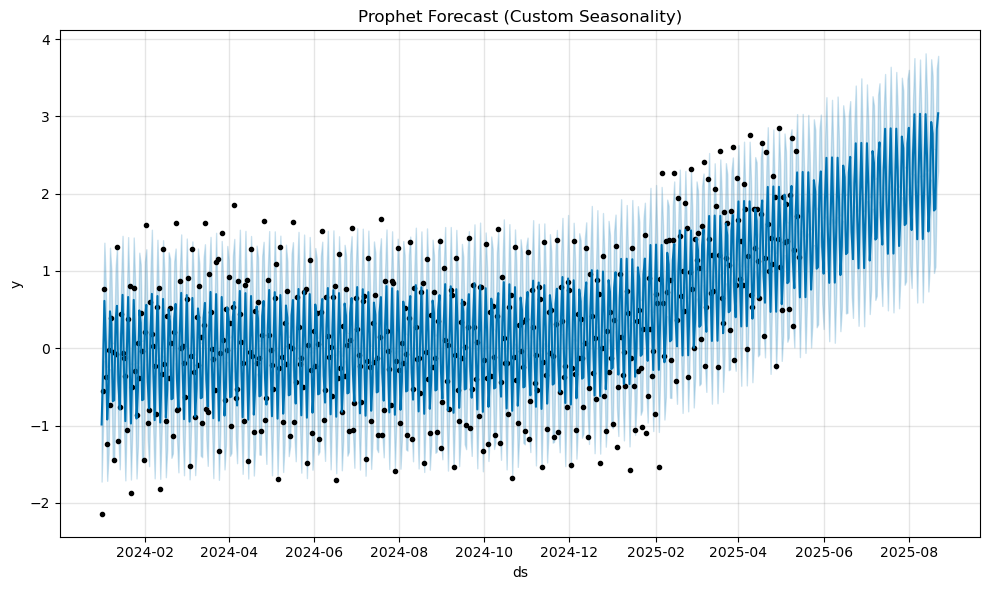

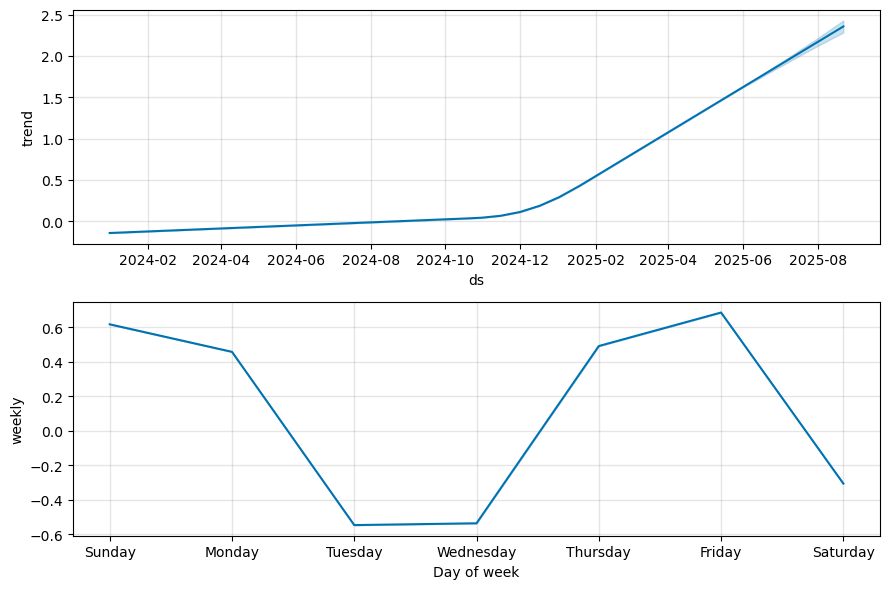

Root Mean Squared Error: 0.60
Mean Absolute Error: 0.50


In [57]:
model = Prophet(weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False)

model.add_seasonality(name='weekly', period=21, fourier_order=6)

model.fit(prophet_train)

future = model.make_future_dataframe(periods=len(prophet_test))
forecast = model.predict(future)

model.plot(forecast)
plt.title("Prophet Forecast (Custom Seasonality)")
plt.tight_layout()
plt.show()

model.plot_components(forecast)
plt.tight_layout()
plt.show()

rmse = root_mean_squared_error(prophet_test.y, forecast.yhat[split_index:])
mae = mean_absolute_error(prophet_test.y, forecast.yhat[split_index:])
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("Mean Absolute Error: {:.2f}".format(mae))

Optimizacijom hiperparametara pogreška se smanjila.